<a href="https://colab.research.google.com/github/auto-d/vision_attacks/blob/main/attacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adversarial Attacks - Adversarial Patches

This notebook is based on a tutorial originally created by Phillip Lippe and modified by Dr. Brinnae Bent for use in "Emerging Trends in Explainable AI" at Duke University.

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/auto-d/vision_attacks/blob/main/attacks.ipynb)


## Dependencies

This section is sourced from the referenced tutorial and sets up the necessary libraries and local copy of an ImageNet subset for training and validation of the patches.


In [1]:
## Standard libraries
import os
import json
import math
import time
import numpy as np
import scipy.linalg

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial10"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

/tmp/ipython-input-1631727475.py:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
INFO:lightning_fabric.utilities.seed:Seed set to 42


Using device cuda:0


In [2]:
import urllib.request
from urllib.error import HTTPError
import zipfile

# Github URL where the dataset is stored for this tutorial

base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial10/"
# Files to download

pretrained_files = [(DATASET_PATH, "TinyImageNet.zip"), (CHECKPOINT_PATH, "patches.zip")]
# Create checkpoint path if it doesn't exist yet
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for dir_name, file_name in pretrained_files:
    file_path = os.path.join(dir_name, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)
        if file_name.endswith(".zip"):
            print("Unzipping file...")
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                zip_ref.extractall(file_path.rsplit("/",1)[0])

Unzipping file...
Unzipping file...


## Setup

This is the tutorial notebook setup, verbatim. We'll use ResNet34 as the target model and repurpose the code for pulling down the ImageNet Tiny subset.

In [3]:
# Load CNN architecture pretrained on ImageNet
os.environ["TORCH_HOME"] = CHECKPOINT_PATH
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
pretrained_model = pretrained_model.to(device)

# No gradients needed for the network
pretrained_model.eval()
for p in pretrained_model.parameters():
    p.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to ../saved_models/tutorial10/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 155MB/s]


In [4]:
# Mean and Std from ImageNet
NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])

# No resizing and center crop necessary as images are already preprocessed.
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN,
                         std=NORM_STD)
])

# Load dataset and create data loader
imagenet_path = os.path.join(DATASET_PATH, "TinyImageNet/")
assert os.path.isdir(imagenet_path), f"Could not find the ImageNet dataset at expected path \"{imagenet_path}\". " + \
                                     f"Please make sure to have downloaded the ImageNet dataset here, or change the {DATASET_PATH=} variable."
dataset = torchvision.datasets.ImageFolder(root=imagenet_path, transform=plain_transforms)
data_loader = data.DataLoader(dataset, batch_size=32, shuffle=False, drop_last=False, num_workers=8)

# Load label names to interpret the label numbers 0 to 999
with open(os.path.join(imagenet_path, "label_list.json"), "r") as f:
    label_names = json.load(f)

def get_label_index(lab_str):
    assert lab_str in label_names, f"Label \"{lab_str}\" not found. Check the spelling of the class."
    return label_names.index(lab_str)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [5]:
def eval_model(dataset_loader, img_func=None):
    """
    Evaluate the model using top 5 accuracy

    NOTE: Sourced from tutorial
    """
    tp, tp_5, counter = 0., 0., 0.
    for imgs, labels in tqdm(dataset_loader, desc="Validating..."):
        imgs = imgs.to(device)
        labels = labels.to(device)
        if img_func is not None:
            imgs = img_func(imgs, labels)
        with torch.no_grad():
            preds = pretrained_model(imgs)
        tp += (preds.argmax(dim=-1) == labels).sum()
        tp_5 += (preds.topk(5, dim=-1)[1] == labels[...,None]).any(dim=-1).sum()
        counter += preds.shape[0]
    acc = tp.float().item()/counter
    top5 = tp_5.float().item()/counter
    print(f"Top-1 error: {(100.0 * (1 - acc)):4.2f}%")
    print(f"Top-5 error: {(100.0 * (1 - top5)):4.2f}%")
    return acc, top5

In [6]:
_ = eval_model(data_loader)

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Top-1 error: 19.38%
Top-5 error: 4.38%


In [7]:
def torch_2_mpl(img):
  """
  Convert a torchviz-style image to a matplot-lib-style image.
  """
  img2 = img.cpu().permute(1, 2, 0).numpy()
  img2 = (img2 * NORM_STD[None,None]) + NORM_MEAN[None,None]
  img2 = np.clip(img2, a_min=0.0, a_max=1.0)
  return img2

In [8]:
def show_prediction(img, label, pred, K=5, adv_img=None, noise=None):
    """
    Utility function to pretty-print the top-K predictions of our model along with
    an optional adversarial image.

    NOTE: 100% sourced from tutorial
    """

    if isinstance(img, torch.Tensor):
        # Tensor image to numpy
        img = img.cpu().permute(1, 2, 0).numpy()
        img = (img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        img = np.clip(img, a_min=0.0, a_max=1.0)
        label = label.item()

    # Plot on the left the image with the true label as title.
    # On the right, have a horizontal bar plot with the top k predictions including probabilities
    if noise is None or adv_img is None:
        fig, ax = plt.subplots(1, 2, figsize=(10,2), gridspec_kw={'width_ratios': [1, 1]})
    else:
        fig, ax = plt.subplots(1, 5, figsize=(12,2), gridspec_kw={'width_ratios': [1, 1, 1, 1, 2]})

    ax[0].imshow(img)
    ax[0].set_title(label_names[label])
    ax[0].axis('off')

    if adv_img is not None and noise is not None:
        # Visualize adversarial images
        adv_img = adv_img.cpu().permute(1, 2, 0).numpy()
        adv_img = (adv_img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        adv_img = np.clip(adv_img, a_min=0.0, a_max=1.0)
        ax[1].imshow(adv_img)
        ax[1].set_title('Adversarial')
        ax[1].axis('off')
        # Visualize noise
        noise = noise.cpu().permute(1, 2, 0).numpy()
        noise = noise * 0.5 + 0.5 # Scale between 0 to 1
        ax[2].imshow(noise)
        ax[2].set_title('Noise')
        ax[2].axis('off')
        # buffer
        ax[3].axis('off')

    if abs(pred.sum().item() - 1.0) > 1e-4:
        pred = torch.softmax(pred, dim=-1)
    topk_vals, topk_idx = pred.topk(K, dim=-1)
    topk_vals, topk_idx = topk_vals.cpu().numpy(), topk_idx.cpu().numpy()
    ax[-1].barh(np.arange(K), topk_vals*100.0, align='center', color=["C0" if topk_idx[i]!=label else "C2" for i in range(K)])
    ax[-1].set_yticks(np.arange(K))
    ax[-1].set_yticklabels([label_names[c] for c in topk_idx])
    ax[-1].invert_yaxis()
    ax[-1].set_xlabel('Confidence')
    ax[-1].set_title('Predictions')

    plt.show()
    plt.close()

Verify we can load and classify a couple of images.

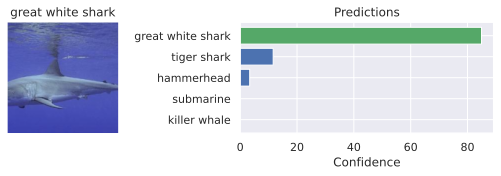

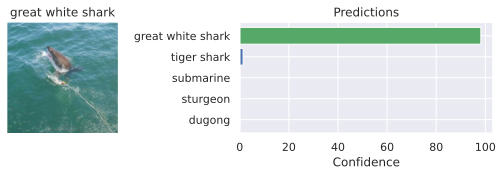

In [9]:

exmp_batch, label_batch = next(iter(data_loader))
with torch.no_grad():
    preds = pretrained_model(exmp_batch.to(device))
for i in range(12,14):
    show_prediction(exmp_batch[i], label_batch[i], preds[i])

## Patch Generation

Here we'll repurpose and extend tutorial logic to provide routines for patch positioning and learning patch pixel values.

In [10]:
TENSOR_MEANS, TENSOR_STD = torch.FloatTensor(NORM_MEAN)[:,None,None], torch.FloatTensor(NORM_STD)[:,None,None]
def patch_forward(patch, mask=None):
    """
    Normalize patch pixels to the imagenet mean & stdev, optionally accepting a mask to operate on (limit operation
    to the mask pixels)

    NOTE: Sourced from tutorial
    """

    # Map patch values from [-infty,infty] to ImageNet min and max, honoring a mask if provided
    if mask:
        patch[mask] = (torch.tanh(patch[mask]) + 1 - 2 * TENSOR_MEANS) / (2 * TENSOR_STD)
    else:
        patch = (torch.tanh(patch) + 1 - 2 * TENSOR_MEANS) / (2 * TENSOR_STD)

    return patch

In [11]:
def slide_patch(batch, patch):
    """
    Randomly position a patch within the provided batch of images
    """
    for i in range(batch.shape[0]):
        h_offset = np.random.randint(0,batch.shape[2]-patch.shape[1]-1)
        w_offset = np.random.randint(0,batch.shape[3]-patch.shape[2]-1)
        batch[i,:,h_offset:h_offset+patch.shape[1],w_offset:w_offset+patch.shape[2]] = patch_forward(patch)
    return batch

In [340]:
from torchvision.transforms.functional import rotate
from torchvision.transforms import InterpolationMode

def rotate_patch(batch, patch):
    """
    Introduce patch rotations with random locations, Accepts a batch of images as returned from a
    dataloader (shape = batch, channel, height, width) and manipulates each independently.
    """

    # For each image in the batch, drop the patch in at a random location and orientation

    for i in range(batch.shape[0]):

        # Rotate this image by a random increment, note this will grow the tensor!
        #angle = np.random.randint(0,360)
        #patch_rot = rotate(img=patch, angle=angle, expand=True, fill=0, interpolation=InterpolationMode.BILINEAR)
        patch_rot = patch

        # Find a random offset and extents for the new, probably larger tensor that still fits all pixels
        y1 = np.random.randint(0,batch.shape[2]-patch_rot.shape[1]-1)
        y2 = y1 + patch_rot.shape[1]
        x1 = np.random.randint(0,batch.shape[3]-patch_rot.shape[2]-1)
        x2 = x1 + patch_rot.shape[2]

        # Capture a mask of our patch pixels to avoid mapping in any fill that resulted from the rotattion
        roi = batch[i, :, y1:y2, x1:x2]
        roi_safe = roi.clone()

        patch_mask = (patch_rot != 1)
        vals = patch_forward(patch_rot)

        merged = torch.where(patch_mask, vals, roi_safe)
        batch[i,:,y1:y2,x1:x2] = merged

        # Copy all normalized patch pixels in, abiding our mask - result will be our original image with a rotated patch overlaid

        #batch[i,:,y1:y2,x1:x2] = torch.where(patch_mask, vals, 0.5)
        #batch[i,:,y1:y2,x1:x2] = patch_forward(patch_rot)

    return batch

In [341]:
def eval_patch(model, patch, val_loader, target_class, rotation=False):
    """
    Evalute the success of a patch from a subset of that validaation set

    NOTE: Sourced from tutorial
    """

    model.eval()
    tp, tp_5, counter = 0., 0., 0.
    with torch.no_grad():
        for img, img_labels in tqdm(val_loader, desc="Validating...", leave=False):

            # For stability, place the patch at 4 random locations per image, and average the performance
            for _ in range(4):
                patch_img = rotate_patch(img, patch) if rotation else slide_patch(img, patch)
                patch_img = patch_img.to(device)
                img_labels = img_labels.to(device)
                pred = model(patch_img)

                # In the accuracy calculation, we need to exclude the images that are of our target class
                # as we would not "fool" the model into predicting those
                tp += torch.logical_and(pred.argmax(dim=-1) == target_class, img_labels != target_class).sum()
                tp_5 += torch.logical_and((pred.topk(5, dim=-1)[1] == target_class).any(dim=-1), img_labels != target_class).sum()
                counter += (img_labels != target_class).sum()
    acc = tp/counter
    top5 = tp_5/counter
    return acc, top5

In [342]:
def patch_attack(model, target_class, patch_size=64, num_epochs=5, rotation=False):
    """
    Generate a patch that is optimized to produce classifications for the target class

    NOTE: Sourced from tutorial
    """

    # Leave a small set of images out to check generalization
    # In most of our experiments, the performance on the hold-out data points
    # was as good as on the training set. Overfitting was little possible due
    # to the small size of the patches.
    train_set, val_set = torch.utils.data.random_split(dataset, [4500, 500])
    train_loader = data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True, num_workers=8)
    val_loader = data.DataLoader(val_set, batch_size=32, shuffle=False, drop_last=False, num_workers=4)

    # Create parameter and optimizer
    if not isinstance(patch_size, tuple):
        patch_size = (patch_size, patch_size)
    patch = nn.Parameter(torch.zeros(3, patch_size[0], patch_size[1]), requires_grad=True)
    optimizer = torch.optim.SGD([patch], lr=1e-1, momentum=0.8)
    loss_module = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(num_epochs):
        t = tqdm(train_loader, leave=False)
        for img, _ in t:
            if rotation:
                img = rotate_patch(img, patch)
            else:
                img = slide_patch(img, patch)

            img = img.to(device)
            pred = model(img)
            labels = torch.zeros(img.shape[0], device=pred.device, dtype=torch.long).fill_(target_class)
            loss = loss_module(pred, labels)
            optimizer.zero_grad()
            with torch.autograd.set_detect_anomaly(True):
              loss.mean().backward()
            optimizer.step()
            t.set_description(f"Epoch {epoch}, Loss: {loss.item():4.2f}")

    # Final validation
    acc, top5 = eval_patch(model, patch, val_loader, target_class, rotation)

    return patch.data, {"acc": acc.item(), "top5": top5.item()}

## Experimentation

First, verify we can learn a patch and inject it. Here are a hanful of Imagnet classes that our resnet model should be capable of predicting:

```
Class ID	Class Name
0	tench, Tinca tinca
1	goldfish, Carassius auratus
2	great white shark, white shark, man-eater, man-eating shark, Carcharodon caharias',
3	tiger shark, Galeocerdo cuvieri
4	hammerhead, hammerhead shark
5	electric ray, crampfish, numbfish, torpedo
6	stingray
7	cock
8	hen
9	ostrich, Struthio camelus
10	brambling, Fringilla montifringilla
```

We'll start by learning patch values to entice the model into predicting a tiger shark as our patch slides around random images. We train for a single epoch to see what sort of performance we get with a relatively small amount of effort.

In [343]:
tiger_shark_class = 4
tiger_shark_class_name = label_names[tiger_shark_class]

In [344]:
patch, results = patch_attack(pretrained_model, target_class=tiger_shark_class, num_epochs=1, rotation=True)

  0%|          | 0/140 [00:00<?, ?it/s]

KeyboardInterrupt: 

Inspect the resulting patch to get an intuition for what's going on.

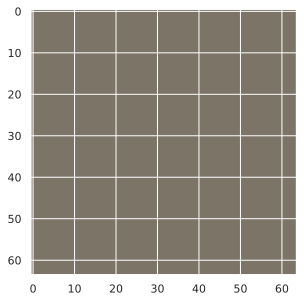

In [321]:
plt.imshow(torch_2_mpl(patch))

Hard to say at one epoch if this is noise actually congealing into shark parts or what. Exciting!

Next, create a pseudo batch to emulate the interface our patching functions expect and make sure we appreciate how these patches are going to be applied to training images.  

In [226]:
batch = dataset[4][0].unsqueeze(0)

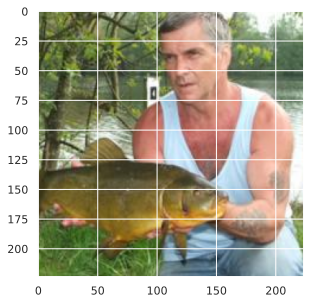

In [227]:
plt.imshow(torch_2_mpl(batch[0]))

Overlay our patch to get a sense for what the model sees during patch training.

In [228]:
im_patch = slide_patch(batch, patch)

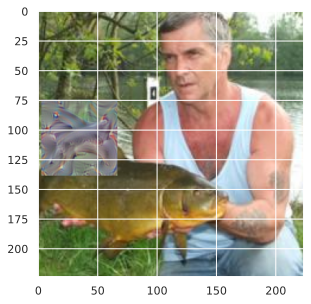

In [229]:
plt.imshow(torch_2_mpl(im_patch[0]))

In [233]:
batch = dataset[6][0].unsqueeze(0)

Now recruit our random offset and orientation function and visualize to confirm it's doing as expected.  

In [234]:
im_rot = rotate_patch(batch, patch)

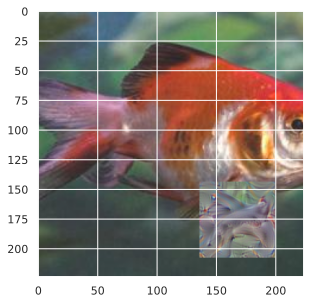

In [235]:
plt.imshow(torch_2_mpl(im_rot[0]))

In [210]:
def get_patches(class_names, patch_sizes):
    """
    Get a set of patches for all permutations of the provided class names and patch sizes.

    NOTE: Adapated from the tutorial
    """
    result_dict = dict()

    # Loop over all classes and patch sizes
    for name in class_names:
        result_dict[name] = dict()
        for patch_size in patch_sizes:
            c = label_names.index(name)
            file_name = os.path.join(CHECKPOINT_PATH, f"{name}_{patch_size}_patch.pt")

            # Load patch if pretrained file exists, otherwise start training
            if not os.path.isfile(file_name):
                patch, val_results = patch_attack(pretrained_model, target_class=c, patch_size=patch_size, num_epochs=5)
                print(f"Validation results for {name} and {patch_size}:", val_results)
                torch.save(patch, file_name)
            else:
                patch = torch.load(file_name)

            # Evaluate the patch
            results = eval_patch(pretrained_model, patch, data_loader, target_class=c)

            # Store results and the patches in a dict for better access
            result_dict[name][patch_size] = {
                "results": results,
                "patch": patch
            }

    return result_dict

Now we train patches in earnest, with multiple geometries. We have a baseline from the tutorial for the pineapple patches and their effectiveness. Preserve that here as a control.

In [211]:
class_names = [tiger_shark_class_name, 'pineapple']
patch_sizes = [64]

patch_dict = get_patches(class_names, patch_sizes)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  0%|          | 0/140 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
patch_dict[tiger_shark_class_name][64]['patch'].shape

Use the demo code to visualize the generated patches.

In [ ]:
def show_patches():
    """
    Patch gallery helper function to get a compact view of what we've built.

    NOTE: Sourced from tutorial!
    """
    fig, ax = plt.subplots(len(patch_sizes), len(class_names), figsize=(len(class_names)*2.2, len(patch_sizes)*2.2))
    for c_idx, cname in enumerate(class_names):
        for p_idx, psize in enumerate(patch_sizes):
            patch = patch_dict[cname][psize]["patch"]
            patch = (torch.tanh(patch) + 1) / 2 # Parameter to pixel values
            patch = patch.cpu().permute(1, 2, 0).numpy()
            patch = np.clip(patch, a_min=0.0, a_max=1.0)
            if p_idx > 1:
              ax[p_idx][c_idx].imshow(patch)
              ax[p_idx][c_idx].set_title(f"{cname}, size {psize}")
              ax[p_idx][c_idx].axis('off')
            else:
              ax[c_idx].imshow(patch)
              ax[c_idx].set_title(f"{cname}, size {psize}")
              ax[c_idx].axis('off')

    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()

show_patches()

Borrowing again from the tutorial we'll pretty print a summary of the patch effectiveness based on validation against a subset of ImageNet.

In [ ]:
import tabulate
from IPython.display import display, HTML

def show_table(top_1=True):
    i = 0 if top_1 else 1
    table = [[name] + [f"{(100.0 * patch_dict[name][psize]['results'][i]):4.2f}%" for psize in patch_sizes]
             for name in class_names]
    display(HTML(tabulate.tabulate(table, tablefmt='html', headers=["Class name"] + [f"Patch size {psize}x{psize}" for psize in patch_sizes])))

First, we will create a table of top-1 accuracy, meaning that how many images have been classified with the target class as highest prediction?

In [ ]:
show_table(top_1=True)

In [ ]:
show_table(top_1=False)

In [ ]:
def perform_patch_attack(patch):
    """
    Now
    """
    patch_batch = exmp_batch.clone()
    patch_batch = rotate_patch(patch_batch, patch)
    with torch.no_grad():
        patch_preds = pretrained_model(patch_batch.to(device))
    for i in range(2,15,4):
        show_prediction(patch_batch[i], label_batch[i], patch_preds[i])

In [ ]:
perform_patch_attack(patch_dict[tiger_shark_class_name][64]['patch'])

In [ ]:
perform_patch_attack(patch_dict['pineapple'][64]['patch'])

## References

This tutorial was originally created by Phillip Lippe.
[![View notebooks on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial10/Adversarial_Attacks.ipynb)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial10/Adversarial_Attacks.ipynb)  

[1] Goodfellow, Ian J., Jonathon Shlens, and Christian Szegedy. "Explaining and harnessing adversarial examples." ICLR 2015.

[2] Hendrik Metzen, Jan, et al. "Universal adversarial perturbations against semantic image segmentation." Proceedings of the IEEE International Conference on Computer Vision. 2017.

[3] Anant Jain. "Breaking neural networks with adversarial attacks." [Blog post](https://towardsdatascience.com/breaking-neural-networks-with-adversarial-attacks-f4290a9a45aa) 2019.